# Recommendation System for Opthalmologists

Today you are a Machine Learning Engineer at Epic Software Systems and your task is to develop a new Recommendation System for opthalmologists (eye doctors).

Diabetic Retinopathy (DR) is a pathology that impacts patients with Diabetes Mellitus 2, such that vision is compromised. Base paper on Automated classification of diabetic retinopathy:
https://ieeexplore.ieee.org/abstract/document/6680633

Diabetic Retinopathy classification using modified AlexNet paper: https://www.sciencedirect.com/science/article/abs/pii/S0045790618334190

Paper available at https://drive.google.com/file/d/1nl5tYA2jJ1Up_malA8uQmvwHu6UH0k-r/view?usp=sharing

Automated classification of DR severity can help streamline the treatment process such that patients with higher severity are seen by the doctor first followed by the less severe patiets. This problem of DR clasification is significant since retinal images are biometrics (unique for each individual) which makes generalized modeling difficult and since 90% of the diabetic population that get imaged each year are have NO DR.

This hard problem can be attacked using the tools of Deep Learning. Today we will show you how to use TensorFlow to construct and train a deep learning model on a small amount of DR data. In the clinic we would like to screen patients with different severity levels of the disease: patients that have NO DR (y=0), vs ones with mild DR (y=1), moderate DR (y=2) and severe DR (y=4). However, in this assignment we're going to make it even easier--the model will just do binary classification: normal images (patients without DR) will be labeled y=0, and those with any amount of DR as y=1.

The purpose of this assignment is to show you the mechanics of using TensorFlow, not to say that what we present is the state-of-the-art in DR classification--far from it. But the ideas we use today are the first steps in an ML pipeline that can get quite-good performance in classifying diabetic retinopathy :)

## Task 1: Setup and Load the Data

1. If using Colab, mount your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Load TensorBoard (Optional).

In [ ]:
%load_ext tensorboard

3. Setup tensorflow.

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

4. The data is stored in the h5 file `1194_DR_smallimages.h5`. h5 stands for Hierarchical Data Format, which is used for multidimensional scientific data. We will use the python module `h5py` to load the data.

    `images` will contain an array of images. Use `plt.imshow` to view a couple of the images to get a sense of what the data looks like.

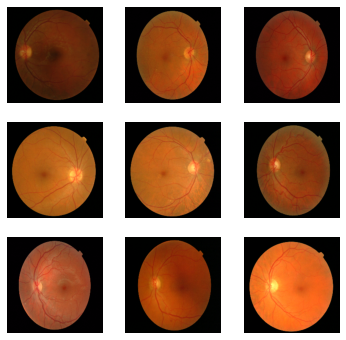

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from random import randint

filepath = '/content/drive/My Drive/FourthBrain/Assignments/Week_5/1194_DR_smallimages.h5'
f = h5py.File(filepath, 'r')
images = np.array(f['images'])
labels = np.array(f['meta']).squeeze()

plt.figure(figsize=(6, 6))
for i in range(0, 9):
    plt.subplot(331 + i)
    plt.axis('off')
    plt.imshow(images[randint(0, images.shape[0] - 1)])

5. How many images are in the dataset?

In [ ]:
images.shape[0]

1194

6. What are the dimensions of the images?

In [ ]:
images.shape

(1194, 227, 227, 3)

7. What are the max and minimum values for the pixel values of the images?

In [ ]:
print('Max and min values of pixels: ', images.max(), images.min())

Max and min values of pixels:  255 0


8. What are the possible label values for the images?

In [ ]:
import numpy as np

np.unique(labels)

array([0, 1, 2, 3], dtype=uint8)

## Task 2: Data Exploration and Preprocessing

1. Plot a histogram illustrating the number of images corresponding to each of the 4 DR severity labels.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Counts')

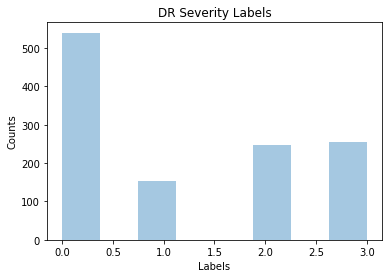

In [ ]:
import seaborn as sns

sns.distplot(x=labels, hist=True, kde=False)
# Add labels
plt.title('DR Severity Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')

2. Scale the images' pixel values so they fall in the range [0, 1]. Call the new array of images `images_scaled`. Verify the max and min of im

In [ ]:
images_scaled = images / images.max()
print('Max and min values of scaled images: ', images_scaled.max(), images_scaled.min())

Max and min values of scaled images:  1.0 0.0


3. While our dataset has 4 labels, we will be using just two based on whether they have Diabetic Retinology or not. 0 means they do not while 1-3 are different levels of severity.

    Because of how the model we are using is implemented, we need one hot encoded columns for the labels. So the labels will be a 2D array where the first column is 1 if the patient doesn't have DR and 0 if they do. The second column is the inverse of this: 1 if the patient has DR and 0 if they don't.
    
    Create the `one_hot_labels` array.

In [ ]:
from tensorflow.keras.utils import to_categorical
import pandas as pd

one_hot_labels = pd.DataFrame(to_categorical(labels))
one_hot_labels.columns = ['nodr', 'dr1', 'dr2', 'dr3']
one_hot_labels['dr'] = np.where((one_hot_labels['dr1'] == 1) | (one_hot_labels['dr2'] == 1) | (one_hot_labels['dr3'] == 1), 1, 0)
one_hot_labels.drop(columns=['dr1', 'dr2', 'dr3'], inplace=True)

one_hot_labels = one_hot_labels.values

print('First value in labels: ', labels[0])
print('First value in one_hot_labels: ', one_hot_labels[0])

First value in labels:  0
First value in one_hot_labels:  [1. 0.]


In [ ]:
one_hot_labels.shape

(1194, 2)

4. Use scikit-learn's `train_test_split()` function to create the training and test sets with a 2/3 - 1/3 split.

    Name the new arrays `X_train`, `X_test`, `Y_train`, and `Y_test`.
    
    Verify the shapes of the four arrays.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images_scaled, one_hot_labels, test_size=0.33, random_state=39)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(799, 227, 227, 3) (395, 227, 227, 3) (799, 2) (395, 2)


5. Plot a histogram to see the relative distribution of the labels between the training and test sets. Plot the data on either one or two plots.

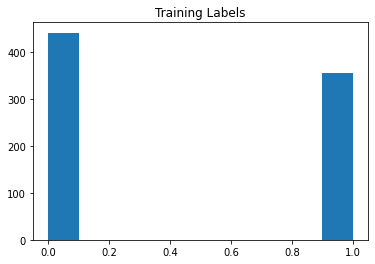

In [ ]:
plt.hist(Y_train[:,0]) 
plt.title("Training Labels") 
plt.show()

## Task 3: Model Definition, Classification and Prediction

1. Use the following definition of the `AlexNet` model.

    You can read more about Alex Net [here](https://towardsdatascience.com/alexnet-the-architecture-that-challenged-cnns-e406d5297951).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11, 11), strides= 4,
                        padding='valid', activation='relu',
                        input_shape= input_shape, kernel_initializer='he_normal'))
        self.add(BatchNormalization())
        self.add(MaxPooling2D(pool_size=(3, 3), strides= (2, 2),
                              padding='valid', data_format=None))


        self.add(Conv2D(256, kernel_size=(5, 5), strides= 1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(BatchNormalization())
        self.add(MaxPooling2D(pool_size=(3, 3), strides= (2, 2),
                              padding='valid', data_format=None)) 


        self.add(Conv2D(384, kernel_size=(3, 3), strides= 1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(BatchNormalization())

        self.add(Conv2D(384, kernel_size=(3, 3), strides= 1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(BatchNormalization())

        self.add(Conv2D(256, kernel_size=(3, 3), strides= 1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(BatchNormalization())

        self.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                              padding='valid', data_format=None))


        self.add(Flatten())

        self.add(Dense(num_classes, activation='softmax'))

        self.compile(optimizer=Adam(learning_rate=0.01),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

2. Instantiate a model using the `AlexNet` class and save it as `model`.

In [ ]:
model = AlexNet((X_train.shape[1], X_train.shape[2], 3), 2)

3. Use the `summary()` method to view a summary of the architecture of the model.

In [ ]:
model.summary()

Model: "alex_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                          

4. Discuss with your classmates your interpretation of this summary. What do these numbers and names represent? (It's okay to speculate.)

The names represent the types of layers added to the model. The numbers represent the number of parameters.

5. Train the model using the `.fit()` method. Save the result as `training_history`.

    Set aside 20% of the data as a validation set. Use a batch size of 20 and train for 40 epochs. Set verbose to True so you get feedback as the model trains.

    Optional: Use TensorBoard to visualize how its properties evolve over the training epochs. To do this, create a log directory and employ a TensorBoard callback. We include code for creating the callback below, but you'll have to pass it in as a parameter o the `.fit()` method.

In [ ]:
from tensorflow import keras
from datetime import datetime

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
training_history = model.fit(X_train, Y_train,
                    batch_size=20, 
                    epochs=40,
                    verbose=True,
                    #callbacks =  tensorboard_callback,
                    validation_data=(X_test, Y_test))

print("Average test loss: ", np.mean(training_history.history['loss']))

Epoch 1/40
40/40 [==============================] - 11s 50ms/step - loss: 13.1266 - accuracy: 0.5269 - val_loss: 633.7551 - val_accuracy: 0.4481
Epoch 2/40
40/40 [==============================] - 1s 24ms/step - loss: 7.8234 - accuracy: 0.5557 - val_loss: 20.9160 - val_accuracy: 0.5215
Epoch 3/40
40/40 [==============================] - 1s 25ms/step - loss: 4.3629 - accuracy: 0.5494 - val_loss: 12.2640 - val_accuracy: 0.4608
Epoch 4/40
40/40 [==============================] - 1s 25ms/step - loss: 3.5222 - accuracy: 0.5782 - val_loss: 3.4100 - val_accuracy: 0.4759
Epoch 5/40
40/40 [==============================] - 1s 24ms/step - loss: 1.8811 - accuracy: 0.6008 - val_loss: 5.1908 - val_accuracy: 0.4633
Epoch 6/40
40/40 [==============================] - 1s 25ms/step - loss: 1.4286 - accuracy: 0.5857 - val_loss: 3.1056 - val_accuracy: 0.4734
Epoch 7/40
40/40 [==============================] - 1s 24ms/step - loss: 1.5613 - accuracy: 0.5820 - val_loss: 4.1983 - val_accuracy: 0.4911
Epoch 8

6. If you're using Colab, run the following lines to change the working directory to where you have uploaded the `helper_functions_for_week5.py` file.

In [ ]:
import os

filepath = '/content/drive/My Drive/FourthBrain/Assignments/Week_5/'
os.chdir(filepath)
pwd = os.getcwd()
print(pwd)

/content/drive/My Drive/FourthBrain/Assignments/Week_5


7. Display loss and accuracy for both the training and validation data.

    Hint: Use the provided functions in `helper_functions_for_week5.py`. 

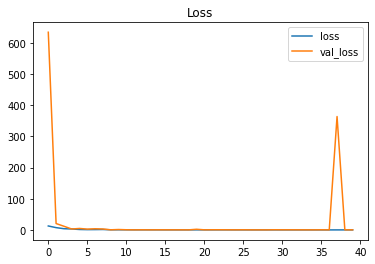

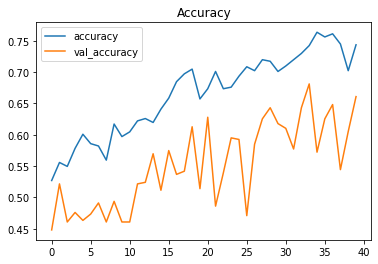

In [ ]:
#These functions are not working well here
#from helper_functions_for_week5 import plot_loss_history, plot_accuracy_history, display_activation
#plot_loss_history(training_history)

history_df = pd.DataFrame(training_history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

8. If you are using tensorboard callbacks, try launching tensorboard to view the logs with one of the following commands:
    
    - If developing locally: `tensorboard --logdir <THIS_DIRECTORY>/logs`
    - If developing on Colab: `%tensorboard --logdir logs`

In [ ]:
#%tensorboard --logdir logs

9. Generate predictions with the test data and save the values as `prediction_values`.

In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)
y_pred[:5]

array([1, 1, 0, 1, 0])

10. Evalute the predictions by calculating the accuracy, precision, recall, f1 score and confusion matrix.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Y_test_bi = np.argmax(Y_test, axis=1)

print('Accuracy: ', accuracy_score(y_pred, Y_test_bi))
print('Precision: ', precision_score(y_pred, Y_test_bi))
print('Recall: ', recall_score(y_pred, Y_test_bi))
print('F1: ', f1_score(y_pred, Y_test_bi))
print('Confusion Matrix: ', confusion_matrix(y_pred, Y_test_bi))

Accuracy:  0.660759493670886
Precision:  0.7311320754716981
Recall:  0.6681034482758621
F1:  0.6981981981981982
Confusion Matrix:  [[106  57]
 [ 77 155]]


11. What do you notice about the performance of this model, especially as it relates to the difference between train and validation accuracy?

This model has a variance problem, so it underfits the training data, and the test data has higher accuracy.

## Task 4: Visualize the Activations.

Source: https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras

1. Extract the output of each layer in the model and save it as the list `layer_outputs`.

In [ ]:
layer_outputs = [layer.output for layer in model.layers]

2. Define a new model `activation_model` with the same input shape as the original model and `layer_outputs` as its outputs.

In [ ]:
from tensorflow.keras.models import Model

activation_model = Model(inputs=model.input, outputs=layer_outputs)

3. Get all the activations by calling the `predict()` method on the number 10 image in `X_train`. Note that even though you're passing a single image, you still need to have 4 dimensions (not just the 3 dimensions of the image). Save the result as `activations`.

In [ ]:
activations = activation_model.predict(X_train[10].reshape(-1, 227,227,3))

4. Display the first 64 activations of the second model layer (layer index 1) in an 8 x 8 grid.

    Hint: Look at the functions `helper_functions_for_week5.py`.

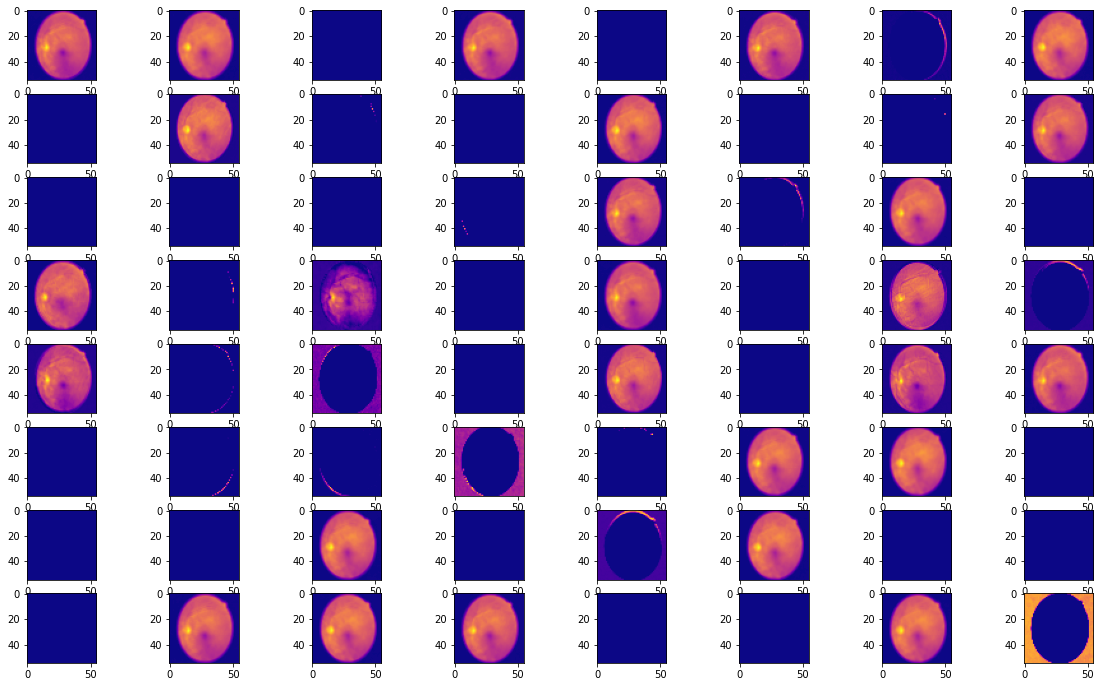

In [ ]:
from helper_functions_for_week5 import display_activation

display_activation(activations, 8, 8, 1)

5. Display the first 64 activations of the 11th model layer (layer index 10) in an 8 x 8 grid.

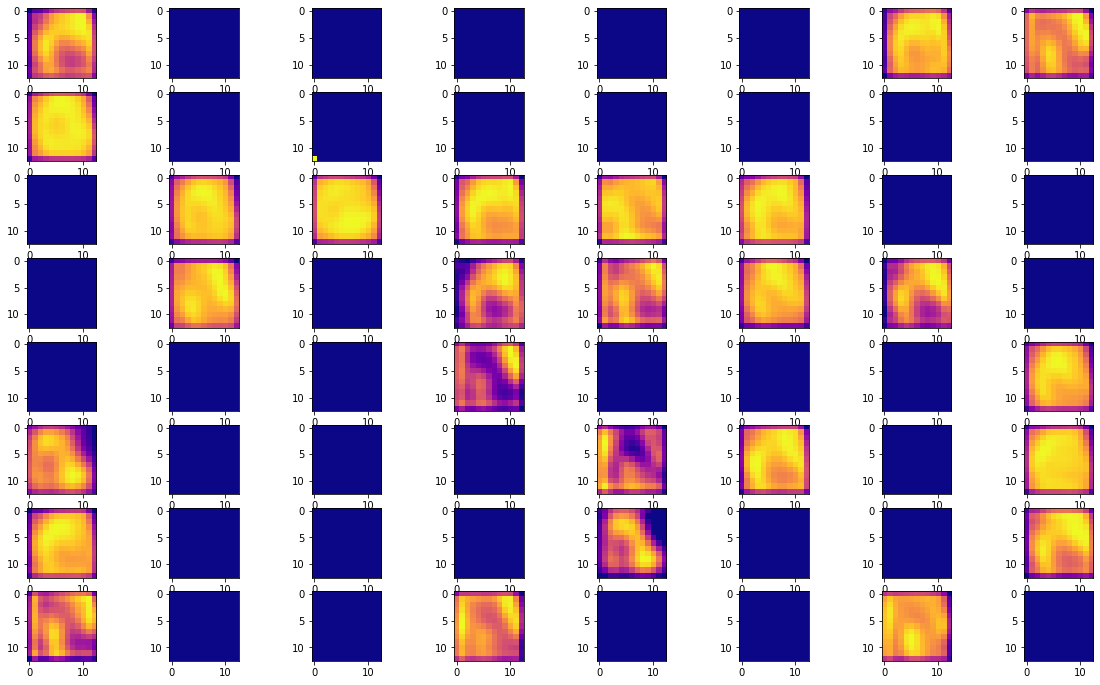

In [ ]:
display_activation(activations, 8, 8, 10)

6. Comment on the activated feature maps for early layers and later layers. What patterns do you observe?

Early layers seem to learn the basic properties of the images, such as edges, corners, etc. Later layers learn high level objects.

## Task 5: Regularization by Data Augmentation [Instructor Led]

We can regularize our model (and, in doing so, hopefully improve it) by augmenting our image data. Image augmentation includes transformations such as rotation, translation, reflection, shearing, and color permutation. TensorFlow provides the `ImageDataGenerator` class to perform image augmentation in memory; by default, your local storage won't save the newly generated images.

1. Create a Data Generator.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True) # add in the desired parameters of an ImageDataGenerator

image_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train)
BATCH_SIZE = X_train.shape[0]

2. Initialize data generator for training/validation and test data sets.

In [ ]:
train_generator = image_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)
test_generator = image_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE)

3. Set useful parameters.

In [ ]:
seed = 0
aug_batch_size = 6

4. View some randomly generated images to gain understanding of the data augmentation process.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0
(6, 227, 227, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


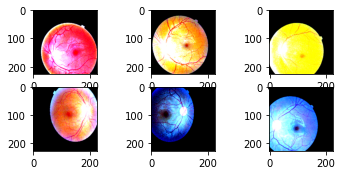

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Epoch 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(6, 227, 227, 3)


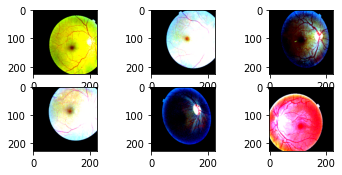

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Epoch 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(6, 227, 227, 3)


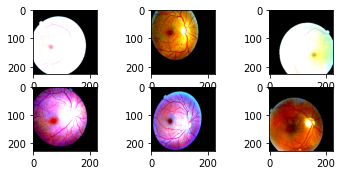

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Epoch 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(6, 227, 227, 3)


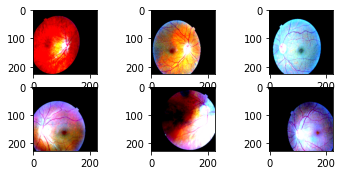

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Epoch 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(6, 227, 227, 3)


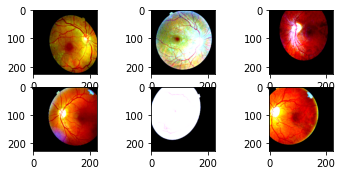

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
for e in range(5):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in image_datagen.flow(X_train, Y_train, batch_size=aug_batch_size):
        print(x_batch.shape)
        for i in range(0, aug_batch_size):
            plt.subplot(330+1 + i)
            plt.imshow(x_batch[i], cmap=plt.get_cmap('gray'))
        plt.show()
        print(y_batch)
        break

There are two methods for using augemented data to train the model.

### Method 1

5. Iterate through randomized `(X, y)` batches generated by `train_generator` and fit `AlexNet` to each one.

    Note: If you have issues with your Colab instance running out of memory, you may have to delete some previously-created variables such as the `model` object holdig the unregularized version of `AlexNet`.

In [ ]:
num_classes=2
model_reg = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), num_classes)

EPOCHS = 40
reg_history_loss = []
reg_history_vloss = []
reg_history_accuracy = []
reg_history_val_accuracy = []

for e in range(EPOCHS):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in train_generator:
        reg_hist = (model_reg.fit(x_batch, y_batch,validation_split=0.2, verbose=1))
        batches += 1
        reg_history_loss.append(reg_hist.history['loss'])
        reg_history_vloss.append(reg_hist.history['val_loss'])
        reg_history_accuracy.append(reg_hist.history['accuracy'])
        reg_history_val_accuracy.append(reg_hist.history['val_accuracy'])
        if batches >= len(X_train) / BATCH_SIZE:
            break

Epoch 0
20/20 [==============================] - 2s 52ms/step - loss: 14.1305 - accuracy: 0.5430 - val_loss: 2364.7361 - val_accuracy: 0.5375
Epoch 1
20/20 [==============================] - 1s 34ms/step - loss: 5.7093 - accuracy: 0.5900 - val_loss: 874.9523 - val_accuracy: 0.4812
Epoch 2
20/20 [==============================] - 1s 34ms/step - loss: 4.9893 - accuracy: 0.5571 - val_loss: 29.2597 - val_accuracy: 0.5562
Epoch 3
20/20 [==============================] - 1s 36ms/step - loss: 4.4377 - accuracy: 0.6041 - val_loss: 52.8616 - val_accuracy: 0.5250
Epoch 4
20/20 [==============================] - 1s 35ms/step - loss: 4.5427 - accuracy: 0.5446 - val_loss: 19.1732 - val_accuracy: 0.6187
Epoch 5
20/20 [==============================] - 1s 34ms/step - loss: 4.4403 - accuracy: 0.5743 - val_loss: 5.1414 - val_accuracy: 0.5188
Epoch 6
20/20 [==============================] - 1s 34ms/step - loss: 4.5927 - accuracy: 0.5430 - val_loss: 8.3189 - val_accuracy: 0.6250
Epoch 7
20/20 [==========

6. Plot the losses and accuracies for both training and validation data

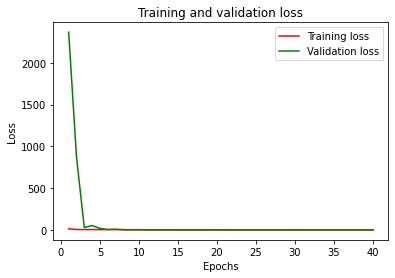

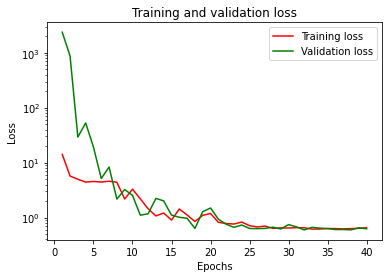

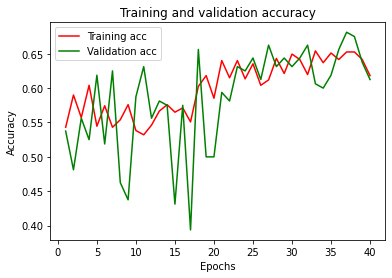

In [ ]:
from helper_functions_for_week5 import plot_loss_history, plot_accuracy_history, display_activation

plot_loss_history({'loss': reg_history_loss, 'val_loss': reg_history_vloss})
plot_loss_history({'loss': reg_history_loss, 'val_loss': reg_history_vloss}, logscale=True)
plot_accuracy_history({'accuracy': reg_history_accuracy, 'val_accuracy': reg_history_val_accuracy})

### Method 2:

7. Pass `train_generator` into the model's `fit()` method directly and abstract away the looping.

In [ ]:
model_reg_2 = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), num_classes)
reg_history = model_reg_2.fit(
    train_generator,
    steps_per_epoch=50,
    verbose=1, 
    epochs=40,
#    callbacks=[tensorboard_callback]
)

print("Average test loss: ", np.average(reg_history.history['loss']))

Epoch 1/40
50/50 [==============================] - 11s 885us/step - loss: 1.3979 - accuracy: 0.4781
Average test loss:  1.3978798389434814


8. Plot the losses and accuracy.

In [ ]:
#This code does not work, no'val_los" in 'reg_history'

plot_loss_history(reg_history.history)
plot_loss_history(reg_history.history, logscale=True)
plot_accuracy_history(reg_history.history)

KeyError: ignored

9. Save the whole trained model to disk.

In [ ]:
model_reg_dir = "reg_model.h5"
model_reg.save(model_reg_dir)  # or model_reg_2 if that's the one you trained

In [ ]:
# %tensorboard --logdir logs

## Task 6: Evaluate the Regularized Model and Report Results

1. Compute the evaluation metrics for the regularized model.

In [ ]:
preds = model_reg.predict(X_test)

y_pred = np.argmax(preds, axis=1)

print('Accuracy: ', accuracy_score(y_pred, Y_test_bi))
print('Precision: ', precision_score(y_pred, Y_test_bi))
print('Recall: ', recall_score(y_pred, Y_test_bi))
print('F1: ', f1_score(y_pred, Y_test_bi))
print('Confusion Matrix: ', confusion_matrix(y_pred, Y_test_bi))

Accuracy:  0.5367088607594936
Precision:  1.0
Recall:  0.5367088607594936
F1:  0.6985172981878088
Confusion Matrix:  [[  0   0]
 [183 212]]


2. Following the same steps as in Task 4, visualize the activations from layers at index 1 and 10 for the regularized model.

In [ ]:
layer_outputs = [layer.output for layer in model_reg.layers]
activation_model = Model(inputs=model_reg.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[10].reshape(-1, 227,227,3))

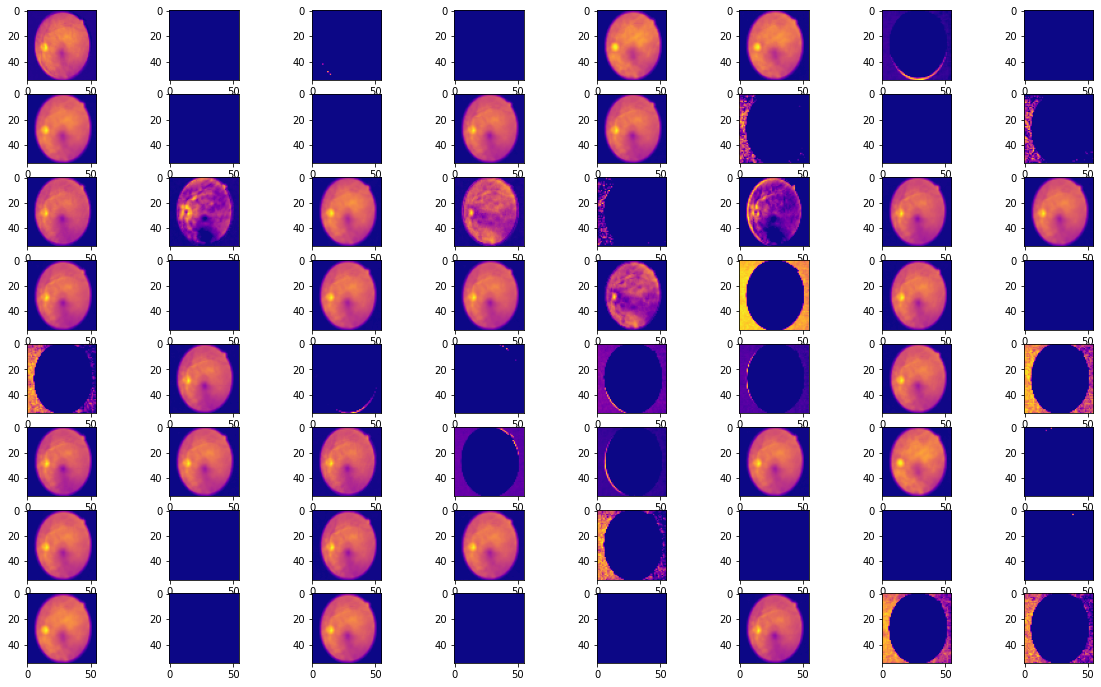

In [ ]:
display_activation(activations, 8, 8, 1)

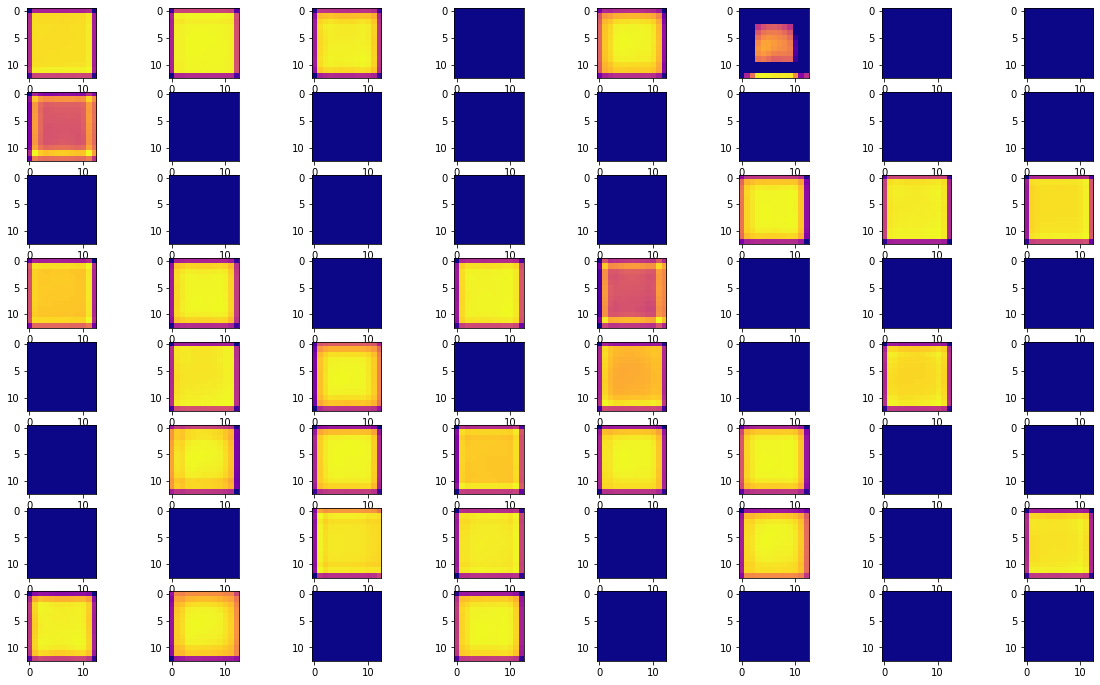

In [ ]:
display_activation(activations, 8, 8, 10)